In [1]:
import json
import collections
from pathlib import Path
from warnings import warn

import numpy as np

from astropy import table

import jwst
from jwst import datamodels

from tqdm.notebook import tqdm

from astropy import visualization

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
dl_path = Path('mastDownload/')

def find_filepath(name, dirpath=dl_path):
    i = dirpath.glob(f'**/{name}')
    l = list(i)
    if len(l) == 0:
        raise ValueError(f'filename {name} is not present in {dirpath}')
    elif len(l)>1:
        warn(f'file {name} has {len(l)} entries in {dirpath}')
    return l[0]
        

In [4]:
n6791_prods = table.Table.read('NGC6791_dataproducts.ecsv', format='ascii.ecsv')

prodmap = {}
local_paths = []
dubious_paths = []
for prod in n6791_prods:
    nm = prod['productFilename']
    if nm in prodmap:
        lpath, dub = prodmap[nm]
        local_paths.append(lpath)
        dubious_paths.append(dub)
    else:
        it = dl_path.glob(f'**/{nm}')
        first = next(it)
        try:
            second = next(it)
        except StopIteration:
            second = None
        local_paths.append(str(first))
        dubious_paths.append(second is not None)
        prodmap[nm] = local_paths[-1], dubious_paths[-1]
n6791_prods['localPath'] = local_paths
n6791_prods['ambiguousLocalPath'] = dubious_paths

n6791_prods

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level,localPath,ambiguousLocalPath
str9,str4,str8,str40,str71,str1,str68,str9,str28,str8,str1,str7,str6,str4,str50,int64,str9,str16,int64,str108,bool
150936210,JWST,spectrum,jw02609-o010_s00010_nirspec_f100lp-g140h,source/target (L3) : association generator,D,mast:JWST/product/jw02609-o010_20230829t055528_spec3_00001_asn.json,INFO,Minimum Recommended Products,ASN,--,CALJWST,1.11.4,2609,jw02609-o010_20230829t055528_spec3_00001_asn.json,4448,150936210,EXCLUSIVE_ACCESS,3,mastDownload/JWST/jw02609-o010_s01765_nirspec_f100lp-g140h/jw02609-o010_20230829t055528_spec3_00001_asn.json,True
150936210,JWST,spectrum,jw02609-o010_s00010_nirspec_f100lp-g140h,source/target (L3) : association pool,D,mast:JWST/product/jw02609_20230829t055528_pool.csv,INFO,Minimum Recommended Products,POOL,--,CALJWST,1.11.4,2609,jw02609_20230829t055528_pool.csv,76603,150936210,EXCLUSIVE_ACCESS,3,mastDownload/JWST/jw02609-o010_s01765_nirspec_f100lp-g140h/jw02609_20230829t055528_pool.csv,True
150936210,JWST,spectrum,jw02609-o010_s00010_nirspec_f100lp-g140h,Preview-Full,D,mast:JWST/product/jw02609-o010_s00010_nirspec_f100lp-g140h_cal.jpg,PREVIEW,--,--,--,CALJWST,1.11.4,2609,jw02609-o010_s00010_nirspec_f100lp-g140h_cal.jpg,3063,150936210,EXCLUSIVE_ACCESS,3,mastDownload/JWST/jw02609-o010_s00010_nirspec_f100lp-g140h/jw02609-o010_s00010_nirspec_f100lp-g140h_cal.jpg,False
150936210,JWST,spectrum,jw02609-o010_s00010_nirspec_f100lp-g140h,Preview-Full,D,mast:JWST/product/jw02609-o010_s00010_nirspec_f100lp-g140h_crf.jpg,PREVIEW,--,--,--,CALJWST,1.11.4,2609,jw02609-o010_s00010_nirspec_f100lp-g140h_crf.jpg,3063,150936210,EXCLUSIVE_ACCESS,3,mastDownload/JWST/jw02609-o010_s00010_nirspec_f100lp-g140h/jw02609-o010_s00010_nirspec_f100lp-g140h_crf.jpg,False
150936210,JWST,spectrum,jw02609-o010_s00010_nirspec_f100lp-g140h,Preview-Full,D,mast:JWST/product/jw02609-o010_s00010_nirspec_f100lp-g140h_s2d.jpg,PREVIEW,--,--,--,CALJWST,1.11.4,2609,jw02609-o010_s00010_nirspec_f100lp-g140h_s2d.jpg,9805,150936210,EXCLUSIVE_ACCESS,3,mastDownload/JWST/jw02609-o010_s00010_nirspec_f100lp-g140h/jw02609-o010_s00010_nirspec_f100lp-g140h_s2d.jpg,False
150936210,JWST,spectrum,jw02609-o010_s00010_nirspec_f100lp-g140h,exposure (L2b): 2D calibrated exposure average over integrations,D,mast:JWST/product/jw02609-o010_s00010_nirspec_f100lp-g140h_cal.fits,SCIENCE,Minimum Recommended Products,CAL,--,CALJWST,1.11.4,2609,jw02609-o010_s00010_nirspec_f100lp-g140h_cal.fits,5126400,150936210,EXCLUSIVE_ACCESS,3,mastDownload/JWST/jw02609-o010_s00010_nirspec_f100lp-g140h/jw02609-o010_s00010_nirspec_f100lp-g140h_cal.fits,False
150936210,JWST,spectrum,jw02609-o010_s00010_nirspec_f100lp-g140h,exposure/target (L2b/L3): 2D Calibrated data averaged over integrations,D,mast:JWST/product/jw02609-o010_s00010_nirspec_f100lp-g140h_crf.fits,SCIENCE,Minimum Recommended Products,CRF,--,CALJWST,1.11.4,2609,jw02609-o010_s00010_nirspec_f100lp-g140h_crf.fits,5708160,150936210,EXCLUSIVE_ACCESS,3,mastDownload/JWST/jw02609-o010_s00010_nirspec_f100lp-g140h/jw02609-o010_s00010_nirspec_f100lp-g140h_crf.fits,False
150936210,JWST,spectrum,jw02609-o010_s00010_nirspec_f100lp-g140h,exposure/target (L2b/L3): 2D image of spectrum avg integrations,D,mast:JWST/product/jw02609-o010_s00010_nirspec_f100lp-g140h_s2d.fits,SCIENCE,Minimum Recommended Products,S2D,--,CALJWST,1.11.4,2609,jw02609-o010_s00010_nirspec_f100lp-g140h_s2d.fits,1696320,150936210,EXCLUSIVE_ACCESS,3,mastDownload/JWST/jw02609-o010_s00010_nirspec_f100lp-g140h/jw02609-o010_s00010_nirspec_f100lp-g140h_s2d.fits,False
150936210,JWST,spectrum,jw02609-o010_s00010_nirspec_f100lp-g140h,exposure/target (L2b/L3): 1D extracted spectrum,D,mast:JWST/product/jw02609-o010_s00010_nirspec_f100lp-g140h_x1d.fits,SCIENCE,Minimum Recommended Products,X1D,--,CALJWST,1.11.4,26

In [5]:
n6791_sci = n6791_prods[n6791_prods['productType'] == 'SCIENCE']
n6791_sci

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level,localPath,ambiguousLocalPath
str9,str4,str8,str40,str71,str1,str68,str9,str28,str8,str1,str7,str6,str4,str50,int64,str9,str16,int64,str108,bool
150936210,JWST,spectrum,jw02609-o010_s00010_nirspec_f100lp-g140h,exposure (L2b): 2D calibrated exposure average over integrations,D,mast:JWST/product/jw02609-o010_s00010_nirspec_f100lp-g140h_cal.fits,SCIENCE,Minimum Recommended Products,CAL,--,CALJWST,1.11.4,2609,jw02609-o010_s00010_nirspec_f100lp-g140h_cal.fits,5126400,150936210,EXCLUSIVE_ACCESS,3,mastDownload/JWST/jw02609-o010_s00010_nirspec_f100lp-g140h/jw02609-o010_s00010_nirspec_f100lp-g140h_cal.fits,False
150936210,JWST,spectrum,jw02609-o010_s00010_nirspec_f100lp-g140h,exposure/target (L2b/L3): 2D Calibrated data averaged over integrations,D,mast:JWST/product/jw02609-o010_s00010_nirspec_f100lp-g140h_crf.fits,SCIENCE,Minimum Recommended Products,CRF,--,CALJWST,1.11.4,2609,jw02609-o010_s00010_nirspec_f100lp-g140h_crf.fits,5708160,150936210,EXCLUSIVE_ACCESS,3,mastDownload/JWST/jw02609-o010_s00010_nirspec_f100lp-g140h/jw02609-o010_s00010_nirspec_f100lp-g140h_crf.fits,False
150936210,JWST,spectrum,jw02609-o010_s00010_nirspec_f100lp-g140h,exposure/target (L2b/L3): 2D image of spectrum avg integrations,D,mast:JWST/product/jw02609-o010_s00010_nirspec_f100lp-g140h_s2d.fits,SCIENCE,Minimum Recommended Products,S2D,--,CALJWST,1.11.4,2609,jw02609-o010_s00010_nirspec_f100lp-g140h_s2d.fits,1696320,150936210,EXCLUSIVE_ACCESS,3,mastDownload/JWST/jw02609-o010_s00010_nirspec_f100lp-g140h/jw02609-o010_s00010_nirspec_f100lp-g140h_s2d.fits,False
150936210,JWST,spectrum,jw02609-o010_s00010_nirspec_f100lp-g140h,exposure/target (L2b/L3): 1D extracted spectrum,D,mast:JWST/product/jw02609-o010_s00010_nirspec_f100lp-g140h_x1d.fits,SCIENCE,Minimum Recommended Products,X1D,--,CALJWST,1.11.4,2609,jw02609-o010_s00010_nirspec_f100lp-g140h_x1d.fits,469440,150936210,EXCLUSIVE_ACCESS,3,mastDownload/JWST/jw02609-o010_s00010_nirspec_f100lp-g140h/jw02609-o010_s00010_nirspec_f100lp-g140h_x1d.fits,False
150936716,JWST,spectrum,jw02609-o010_s00021_nirspec_f100lp-g140h,exposure (L2b): 2D calibrated exposure average over integrations,D,mast:JWST/product/jw02609-o010_s00021_nirspec_f100lp-g140h_cal.fits,SCIENCE,Minimum Recommended Products,CAL,--,CALJWST,1.11.4,2609,jw02609-o010_s00021_nirspec_f100lp-g140h_cal.fits,7315200,150936716,EXCLUSIVE_ACCESS,3,mastDownload/JWST/jw02609-o010_s00021_nirspec_f100lp-g140h/jw02609-o010_s00021_nirspec_f100lp-g140h_cal.fits,False
150936716,JWST,spectrum,jw02609-o010_s00021_nirspec_f100lp-g140h,exposure/target (L2b/L3): 2D Calibrated data averaged over integrations,D,mast:JWST/product/jw02609-o010_s00021_nirspec_f100lp-g140h_crf.fits,SCIENCE,Minimum Recommended Products,CRF,--,CALJWST,1.11.4,2609,jw02609-o010_s00021_nirspec_f100lp-g140h_crf.fits,8170560,150936716,EXCLUSIVE_ACCESS,3,mastDownload/JWST/jw02609-o010_s00021_nirspec_f100lp-g140h/jw02609-o010_s00021_nirspec_f100lp-g140h_crf.fits,False
150936716,JWST,spectrum,jw02609-o010_s00021_nirspec_f100lp-g140h,exposure/target (L2b/L3): 2D image of spectrum avg integrations,D,mast:JWST/product/jw02609-o010_s00021_nirspec_f100lp-g140h_s2d.fits,SCIENCE,Minimum Recommended Products,S2D,--,CALJWST,1.11.4,2609,jw02609-o010_s00021_nirspec_f100lp-g140h_s2d.fits,2318400,150936716,EXCLUSIVE_ACCESS,3,mastDownload/JWST/jw02609-o010_s00021_nirspec_f100lp-g140h/jw02609-o010_s00021_nirspec_f100lp-g140h_s2d.fits,False
150936716,JWST,spectrum,jw02609-o010_s00021_nirspec_f100lp-g140h,exposure/target (L2b/L3): 1D extracted spectrum,D,mast:JWST/product/jw02609-o010_s00021_nirspec_f100lp-g140h_x1d.fits,SCIENCE,Minimum Recommended Products,X1D,--,CALJWST,1.11.4,2609,jw02609-o010_s00021_nirspec_f100lp-g140h_x1d.fits,645120,150936716,EXCLUSIVE_ACCESS,3,mastDownload/JWST/jw02

In [6]:
pairs = {}
for row in n6791_sci:
    pair = (row['description'], row['productSubGroupDescription'])
    if pair in pairs:
        pairs[pair] += 1
    else:
        pairs[pair] = 1
pairs

{('exposure (L2b): 2D calibrated exposure average over integrations',
  'CAL'): 763,
 ('exposure/target (L2b/L3): 2D Calibrated data averaged over integrations',
  'CRF'): 69,
 ('exposure/target (L2b/L3): 2D image of spectrum avg integrations',
  'S2D'): 345,
 ('exposure/target (L2b/L3): 1D extracted spectrum', 'X1D'): 345,
 ('exposure (L2a): 2D count rate averaged over integrations', 'RATE'): 694,
 ('exposure (L2a): 3D countrate per integration', 'RATEINTS'): 694,
 ('exposure (L1b): Uncalibrated 4D exposure data', 'UNCAL'): 694}

Based on this there should be one x1d file at level 3 for each slit with all the relevant info for association.

In [7]:
x1d_3s = n6791_sci[(n6791_sci['calib_level'] == 3)&(n6791_sci['productSubGroupDescription'] == 'X1D')]
x1d_3s.show_in_notebook()

idx,obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level,localPath,ambiguousLocalPath
0,150936210,JWST,spectrum,jw02609-o010_s00010_nirspec_f100lp-g140h,exposure/target (L2b/L3): 1D extracted spectrum,D,mast:JWST/product/jw02609-o010_s00010_nirspec_f100lp-g140h_x1d.fits,SCIENCE,Minimum Recommended Products,X1D,--,CALJWST,1.11.4,2609,jw02609-o010_s00010_nirspec_f100lp-g140h_x1d.fits,469440,150936210,EXCLUSIVE_ACCESS,3,mastDownload/JWST/jw02609-o010_s00010_nirspec_f100lp-g140h/jw02609-o010_s00010_nirspec_f100lp-g140h_x1d.fits,False
1,150936716,JWST,spectrum,jw02609-o010_s00021_nirspec_f100lp-g140h,exposure/target (L2b/L3): 1D extracted spectrum,D,mast:JWST/product/jw02609-o010_s00021_nirspec_f100lp-g140h_x1d.fits,SCIENCE,Minimum Recommended Products,X1D,--,CALJWST,1.11.4,2609,jw02609-o010_s00021_nirspec_f100lp-g140h_x1d.fits,645120,150936716,EXCLUSIVE_ACCESS,3,mastDownload/JWST/jw02609-o010_s00021_nirspec_f100lp-g140h/jw02609-o010_s00021_nirspec_f100lp-g140h_x1d.fits,False
2,150936279,JWST,spectrum,jw02609-o010_s00038_nirspec_f100lp-g140h,exposure/target (L2b/L3): 1D extracted spectrum,D,mast:JWST/product/jw02609-o010_s00038_nirspec_f100lp-g140h_x1d.fits,SCIENCE,Minimum Recommended Products,X1D,--,CALJWST,1.11.4,2609,jw02609-o010_s00038_nirspec_f100lp-g140h_x1d.fits,380160,150936279,EXCLUSIVE_ACCESS,3,mastDownload/JWST/jw02609-o010_s00038_nirspec_f100lp-g140h/jw02609-o010_s00038_nirspec_f100lp-g140h_x1d.fits,False
3,150936236,JWST,spectrum,jw02609-o010_s00040_nirspec_f100lp-g140h,exposure/target (L2b/L3): 1D extracted spectrum,D,mast:JWST/product/jw02609-o010_s00040_nirspec_f100lp-g140h_x1d.fits,SCIENCE,Minimum Recommended Products,X1D,--,CALJWST,1.11.4,2609,jw02609-o010_s00040_nirspec_f100lp-g140h_x1d.fits,385920,150936236,EXCLUSIVE_ACCESS,3,mastDownload/JWST/jw02609-o010_s00040_nirspec_f100lp-g140h/jw02609-o010_s00040_nirspec_f100lp-g140h_x1d.fits,False
4,150936529,JWST,spectrum,jw02609-o010_s00042_nirspec_f100lp-g140h,exposure/target (L2b/L3): 1D extracted spectrum,D,mast:JWST/product/jw02609-o010_s00042_nirspec_f100lp-g140h_x1d.fits,SCIENCE,Minimum Recommended Products,X1D,--,CALJWST,1.11.4,2609,jw02609-o010_s00042_nirspec_f100lp-g140h_x1d.fits,385920,150936529,EXCLUSIVE_ACCESS,3,mastDownload/JWST/jw02609-o010_s00042_nirspec_f100lp-g140h/jw02609-o010_s00042_nirspec_f100lp-g140h_x1d.fits,False
5,150936060,JWST,spectrum,jw02609-o010_s00066_nirspec_f100lp-g140h,exposure/target (L2b/L3): 1D extracted spectrum,D,mast:JWST/product/jw02609-o010_s00066_nirspec_f100lp-g140h_x1d.fits,SCIENCE,Minimum Recommended Products,X1D,--,CALJWST,1.11.4,2609,jw02609-o010_s00066_nirspec_f100lp-g140h_x1d.fits,564480,150936060,EXCLUSIVE_ACCESS,3,mastDownload/JWST/jw02609-o010_s00066_nirspec_f100lp-g140h/jw02609-o010_s00066_nirspec_f100lp-g140h_x1d.fits,False
6,150936508,JWST,spectrum,jw02609-o010_s00075_nirspec_f100lp-g140h,exposure/target (L2b/L3): 1D extracted spectrum,D,mast:JWST/product/jw02609-o010_s00075_nirspec_f100lp-g140h_x1d.fits,SCIENCE,Minimum Recommended Products,X1D,--,CALJWST,1.11.4,2609,jw02609-o010_s00075_nirspec_f100lp-g140h_x1d.fits,388800,150936508,EXCLUSIVE_ACCESS,3,mastDownload/JWST/jw02609-o010_s00075_nirspec_f100lp-g140h/jw02609-o010_s00075_nirspec_f100lp-g140h_x1d.fits,False
7,150936609,JWST,spectrum,jw02609-o010_s00085_nirspec_f100lp-g140h,exposure/target (L2b/L3): 1D extracted spectrum,D,mast:JWST/product/jw02609-o010_s00085_nirspec_f100lp-g140h_x1d.fits,SCIENCE,Minimum Recommended Products,X1D,--,CALJWST,1.11.4,2609,jw02609-o010_s00085_nirspec_f100lp-g140h_x1d.fits,590400,150936609,EXCLUSIVE_ACCESS,3,mastDownload/JWST/jw02609-o010_s00085_nirspec_f100lp-g140h/jw02609-o010_s00085_nirspec_f100lp-g140h_x1d.fits,False
8,150936364,JWST,spectrum,jw02609-o010_s00138_nirspec_f100lp-g140h,exposure/target (L2b/L3): 1D extracted spectrum,D,mast:

In [8]:
for p in x1d_3s['localPath']:
    with datamodels.open(p) as f:
        s = f.spec[0]
        print(s.source_id, s.source_name, s.name)
        print(s.slit_ra, s.slit_dec, s.slitlet_id)

10 2609_10 NRS_MSASPEC
290.219133911901 37.7411574493274 42
21 2609_21 NRS_MSASPEC
290.2536255743246 37.759424215903756 67
38 2609_38 NRS_MSASPEC
290.1882188496649 37.7427598548022 16
40 2609_40 NRS_MSASPEC
290.207187181158 37.72849648922625 21
42 2609_42 NRS_MSASPEC
290.20996674543403 37.725955344660775 20
66 2609_66 NRS_MSASPEC
290.2140684282573 37.77515450575545 57
75 2609_75 NRS_MSASPEC
290.21178776705335 37.7248044919993 23
85 2609_85 NRS_MSASPEC
290.2488897154988 37.74733981497815 59
138 2609_138 NRS_MSASPEC
290.222859727212 37.72592992931399 35
150 2609_150 NRS_MSASPEC
290.21848368303745 37.787562517919845 64
153 2609_153 NRS_MSASPEC
290.2467587424313 37.76825361149515 70
154 2609_154 NRS_MSASPEC
290.1931913539258 37.76522737043734 43
181 2609_181 NRS_MSASPEC
290.2306145504614 37.78191349759346 69
456 2609_456 NRS_MSASPEC
290.2158699671621 37.71725512436535 14
462 2609_462 NRS_MSASPEC
290.2162312297504 37.71892694684022 19
593 2609_593 NRS_MSASPEC
290.202234365479 37.72154160008

In [9]:
slitname_to_info = {}
for row in x1d_3s:
    with datamodels.open(row['localPath']) as f:
        s = f.spec[0]
        slitname_to_info[s.source_name] = d = {}
        for nm in 'slit_ra,slit_dec,source_ra,source_dec,slitlet_id,source_alias'.split(','):
            d[nm] = getattr(s, nm)
        d['asn_pool_name'] = f.meta.asn.pool_name
        d['asn_table_name'] = f.meta.asn.table_name

In [10]:
slitname_to_asn_pool = {}
slitname_to_asn_table = {}

for k, d in slitname_to_info.items():
    nm = None
    try:
        nm = next(dl_path.glob(f'**/{d["asn_pool_name"]}'))
    except StopIteration:
        slitname_to_asn_pool[k] = None
    if nm is not None:
        slitname_to_asn_pool[k] = table.Table.read(nm, format='ascii', delimiter='|')

    nm = None
    try:
        nm = next(dl_path.glob(f'**/{d["asn_table_name"]}'))
    except StopIteration:
        slitname_to_asn_table[k] =  None
    if nm is not None:
        with open(nm) as f:
            slitname_to_asn_table[k] = json.load(f)

In [11]:
cal_files = set()
for nm, t in slitname_to_asn_table.items():
    for prod in t['products']:
        for file in prod['members']:
            if file['exptype'] == 'science':
                cal_files.add(file['expname'])
cal_files

{'jw02609010001_03101_00001_nrs1_cal.fits',
 'jw02609010001_03101_00001_nrs2_cal.fits',
 'jw02609010001_03101_00002_nrs1_cal.fits',
 'jw02609010001_03101_00002_nrs2_cal.fits'}

In [12]:
set(n6791_sci[(n6791_sci['productSubGroupDescription']=='CAL')&(n6791_sci['calib_level']==2)&(n6791_sci['dataproduct_type']=='spectrum')]['productFilename'])

{'jw02609010001_03101_00001_nrs1_cal.fits',
 'jw02609010001_03101_00001_nrs2_cal.fits',
 'jw02609010001_03101_00002_nrs1_cal.fits',
 'jw02609010001_03101_00002_nrs2_cal.fits'}

In [13]:
set(n6791_sci[(n6791_sci['productSubGroupDescription']=='CAL')&(n6791_sci['calib_level']==2)&(n6791_sci['dataproduct_type']=='spectrum')]['obsID'])

{'150909866', '150909868', '150909879', '150909892'}

In [14]:
n6791_sci[(n6791_sci['productSubGroupDescription']=='CAL')&(n6791_sci['calib_level']==2)&(n6791_sci['dataproduct_type']=='spectrum')]

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level,localPath,ambiguousLocalPath
str9,str4,str8,str40,str71,str1,str68,str9,str28,str8,str1,str7,str6,str4,str50,int64,str9,str16,int64,str108,bool
150909868,JWST,spectrum,jw02609010001_03101_00001_nrs1,exposure (L2b): 2D calibrated exposure average over integrations,S,mast:JWST/product/jw02609010001_03101_00001_nrs1_cal.fits,SCIENCE,--,CAL,--,CALJWST,1.10.1,2609,jw02609010001_03101_00001_nrs1_cal.fits,33534720,150936060,EXCLUSIVE_ACCESS,2,mastDownload/JWST/jw02609010001_03101_00001_nrs1/jw02609010001_03101_00001_nrs1_cal.fits,False
150909868,JWST,spectrum,jw02609010001_03101_00001_nrs1,exposure (L2b): 2D calibrated exposure average over integrations,S,mast:JWST/product/jw02609010001_03101_00001_nrs1_cal.fits,SCIENCE,--,CAL,--,CALJWST,1.10.1,2609,jw02609010001_03101_00001_nrs1_cal.fits,33534720,150936070,EXCLUSIVE_ACCESS,2,mastDownload/JWST/jw02609010001_03101_00001_nrs1/jw02609010001_03101_00001_nrs1_cal.fits,False
150909868,JWST,spectrum,jw02609010001_03101_00001_nrs1,exposure (L2b): 2D calibrated exposure average over integrations,S,mast:JWST/product/jw02609010001_03101_00001_nrs1_cal.fits,SCIENCE,--,CAL,--,CALJWST,1.10.1,2609,jw02609010001_03101_00001_nrs1_cal.fits,33534720,150936080,EXCLUSIVE_ACCESS,2,mastDownload/JWST/jw02609010001_03101_00001_nrs1/jw02609010001_03101_00001_nrs1_cal.fits,False
150909868,JWST,spectrum,jw02609010001_03101_00001_nrs1,exposure (L2b): 2D calibrated exposure average over integrations,S,mast:JWST/product/jw02609010001_03101_00001_nrs1_cal.fits,SCIENCE,--,CAL,--,CALJWST,1.10.1,2609,jw02609010001_03101_00001_nrs1_cal.fits,33534720,150936090,EXCLUSIVE_ACCESS,2,mastDownload/JWST/jw02609010001_03101_00001_nrs1/jw02609010001_03101_00001_nrs1_cal.fits,False
150909868,JWST,spectrum,jw02609010001_03101_00001_nrs1,exposure (L2b): 2D calibrated exposure average over integrations,S,mast:JWST/product/jw02609010001_03101_00001_nrs1_cal.fits,SCIENCE,--,CAL,--,CALJWST,1.10.1,2609,jw02609010001_03101_00001_nrs1_cal.fits,33534720,150936101,EXCLUSIVE_ACCESS,2,mastDownload/JWST/jw02609010001_03101_00001_nrs1/jw02609010001_03101_00001_nrs1_cal.fits,False
150909868,JWST,spectrum,jw02609010001_03101_00001_nrs1,exposure (L2b): 2D calibrated exposure average over integrations,S,mast:JWST/product/jw02609010001_03101_00001_nrs1_cal.fits,SCIENCE,--,CAL,--,CALJWST,1.10.1,2609,jw02609010001_03101_00001_nrs1_cal.fits,33534720,150936112,EXCLUSIVE_ACCESS,2,mastDownload/JWST/jw02609010001_03101_00001_nrs1/jw02609010001_03101_00001_nrs1_cal.fits,False
150909868,JWST,spectrum,jw02609010001_03101_00001_nrs1,exposure (L2b): 2D calibrated exposure average over integrations,S,mast:JWST/product/jw02609010001_03101_00001_nrs1_cal.fits,SCIENCE,--,CAL,--,CALJWST,1.10.1,2609,jw02609010001_03101_00001_nrs1_cal.fits,33534720,150936121,EXCLUSIVE_ACCESS,2,mastDownload/JWST/jw02609010001_03101_00001_nrs1/jw02609010001_03101_00001_nrs1_cal.fits,False
150909868,JWST,spectrum,jw02609010001_03101_00001_nrs1,exposure (L2b): 2D calibrated exposure average over integrations,S,mast:JWST/product/jw02609010001_03101_00001_nrs1_cal.fits,SCIENCE,--,CAL,--,CALJWST,1.10.1,2609,jw02609010001_03101_00001_nrs1_cal.fits,33534720,150936135,EXCLUSIVE_ACCESS,2,mastDownload/JWST/jw02609010001_03101_00001_nrs1/jw02609010001_03101_00001_nrs1_cal.fits,False
150909868,JWST,spectrum,jw02609010001_03101_00001_nrs1,exposure (L2b): 2D calibrated exposure average over integrations,S,mast:JWST/product/jw02609010001_03101_00001_nrs1_cal.fits,SCIENCE,--,CAL,--,CALJWST,1.10.1,2609,jw02609010001_03101_00001_nrs1_cal.fits,33534720,150936147,EXCLUSIVE_ACCESS,2,mastDownload/JWST/jw02609010001_03101_00001_nrs1/jw02609010001_03101_00001_nrs1_cal.fits,False


In [15]:
t = n6791_sci.copy()[(n6791_sci['productSubGroupDescription']=='CAL')&(n6791_sci['calib_level']==2)&(n6791_sci['dataproduct_type']=='spectrum')]
print(len(t))

t.remove_column('parent_obsid')
# t.remove_column('productGroupDescription')
# t.remove_column('productDocumentationURL')
# t.remove_column('prvversion')
ucal_tab = table.unique(t, silent=True)
ucal_tab

276


obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,dataRights,calib_level,localPath,ambiguousLocalPath
str9,str4,str8,str40,str71,str1,str68,str9,str28,str8,str1,str7,str6,str4,str50,int64,str16,int64,str108,bool
150909866,JWST,spectrum,jw02609010001_03101_00001_nrs2,exposure (L2b): 2D calibrated exposure average over integrations,S,mast:JWST/product/jw02609010001_03101_00001_nrs2_cal.fits,SCIENCE,--,CAL,--,CALJWST,1.10.1,2609,jw02609010001_03101_00001_nrs2_cal.fits,153881280,EXCLUSIVE_ACCESS,2,mastDownload/JWST/jw02609010001_03101_00001_nrs2/jw02609010001_03101_00001_nrs2_cal.fits,False
150909868,JWST,spectrum,jw02609010001_03101_00001_nrs1,exposure (L2b): 2D calibrated exposure average over integrations,S,mast:JWST/product/jw02609010001_03101_00001_nrs1_cal.fits,SCIENCE,--,CAL,--,CALJWST,1.10.1,2609,jw02609010001_03101_00001_nrs1_cal.fits,33534720,EXCLUSIVE_ACCESS,2,mastDownload/JWST/jw02609010001_03101_00001_nrs1/jw02609010001_03101_00001_nrs1_cal.fits,False
150909879,JWST,spectrum,jw02609010001_03101_00002_nrs2,exposure (L2b): 2D calibrated exposure average over integrations,S,mast:JWST/product/jw02609010001_03101_00002_nrs2_cal.fits,SCIENCE,--,CAL,--,CALJWST,1.10.1,2609,jw02609010001_03101_00002_nrs2_cal.fits,154019520,EXCLUSIVE_ACCESS,2,mastDownload/JWST/jw02609010001_03101_00002_nrs2/jw02609010001_03101_00002_nrs2_cal.fits,False
150909892,JWST,spectrum,jw02609010001_03101_00002_nrs1,exposure (L2b): 2D calibrated exposure average over integrations,S,mast:JWST/product/jw02609010001_03101_00002_nrs1_cal.fits,SCIENCE,--,CAL,--,CALJWST,1.10.1,2609,jw02609010001_03101_00002_nrs1_cal.fits,33534720,EXCLUSIVE_ACCESS,2,mastDownload/JWST/jw02609010001_03101_00002_nrs1/jw02609010001_03101_00002_nrs1_cal.fits,False


All the derived spectral products go back to just 4 cal files, despite there being hundreds of products, all different seemingly only in their parent id.  Boggles the mind.

In [16]:
dm = datamodels.open(ucal_tab['localPath'][1])

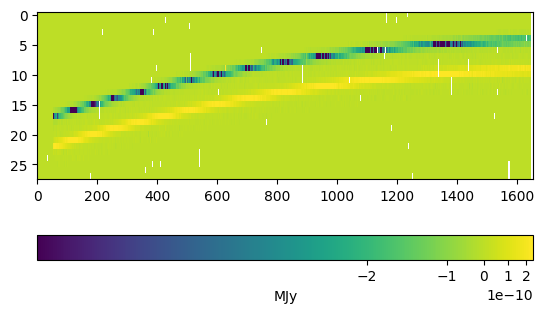

In [17]:
slit = dm.slits[-15]
visualization.imshow_norm(slit.data, aspect=20,
                          interval=visualization.PercentileInterval(99),
                          stretch=visualization.LogStretch(),
                          interpolation='nearest'
                         )
plt.colorbar(orientation='horizontal').set_label(slit.meta.bunit_data)

In [18]:
list(slit.items())[-6:]

[('xcen', 325),
 ('xsize', 1654),
 ('xstart', 395),
 ('ycen', 128),
 ('ysize', 28),
 ('ystart', 1390)]

In [19]:
asn = json.load(open(find_filepath(dm.meta.asn.table_name)))
fn = find_filepath(asn['products'][0]['members'][0]['expname'])
print(fn)
fr = datamodels.open(fn)

mastDownload/JWST/jw02609010001_03101_00001_nrs1/jw02609010001_03101_00001_nrs1_rate.fits


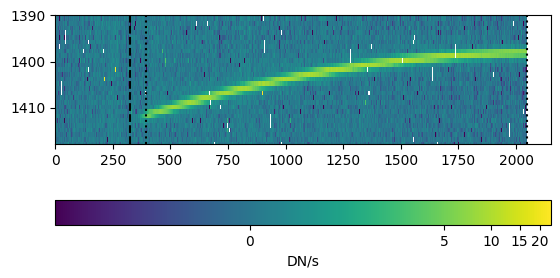

In [20]:
visualization.imshow_norm(fr.data,
                          interval=visualization.PercentileInterval(99),
                          stretch=visualization.LogStretch(),
                          interpolation='nearest', 
                          aspect=20)

plt.ylim(slit.ystart + slit.ysize, slit.ystart)
plt.axvline(slit.xstart, c='k', ls=':')
plt.axvline(slit.xstart + slit.xsize, c='k', ls=':')
plt.axvline(slit.xcen, c='k', ls='--')
plt.colorbar(orientation='horizontal').set_label(fr.meta.bunit_data)